## Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
from datetime import datetime
import logging, os
from numba import njit, jit
import matplotlib.animation as ani

## Set logger to log caching activity

In [2]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Version of 21cmFAST

In [3]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.0.dev5


## Number of cores running

In [4]:
print(f'Number of threads running = {os.cpu_count()}')

Number of threads running = 16


## Reset cache location 

In [5]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Cosmological Parameters (Default is used when no input is specified)

In [6]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [7]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [8]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-12-27 11:26:04.875262


2020-12-27 11:28:32,115 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-12-27 11:28:32.117507
Execution time = 0:02:27.242245


## Generate ionized boxes and total neutral fractions as a function of redshift

In [9]:
ionized_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond
).xH_box
total_neutral_fraction = np.mean(ionized_box)
        
total_neutral_fraction

2020-12-27 11:28:33,803 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


0.18918048

## MFP3D & 2D

In [10]:
from scipy.interpolate import RegularGridInterpolator
import sys

def mfp3d(arr, xth=0.5, iterations=10000000, verbose=True):
    #3D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info = arr.shape  # dimentions of the data box

#=========================================================================================================
    longest = int(max(arr.shape)*np.sqrt(3))  
    # longest distance between 2 points in the box, i.e. diagonal corners
    # EDIT: switch the definition of longest to sqrt(3)*longest
#=========================================================================================================
    
    num_sz  = np.zeros(longest)  # place holder with length of the longest axis

    ar  = np.zeros(arr.shape)  # place holder with data box shape
    ar[arr >= xth] = 1  # generating a binary box, xth = threshold

    loc = np.argwhere(ar == 1)  # locations of ionized cells
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)  
    # iterations number of random ionized locations
 
    #==================================================================================
    thetas   = np.random.randint(0, 180, size=iterations)  # should it be 0 to 180 deg?
    # EDIT: switched upper limit from 360 to 180.
    #==================================================================================

    phis     = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)*np.cos(phis*np.pi/180)  # dx
    ms       = np.sin(thetas*np.pi/180)*np.sin(phis*np.pi/180)  # dy
    ns       = np.cos(thetas*np.pi/180)  # dz
    xs,ys,zs = loc[rand_loc,0],loc[rand_loc,1],loc[rand_loc,2]  
    # slicing ionized locations with [randome coordinate, (x,y,z)]

    interp_func = RegularGridInterpolator(
        (np.arange(info[0]), np.arange(info[1]), np.arange(info[2])), 
        ar, 
        bounds_error=False, 
        fill_value=0
    )
    
    xxs = np.zeros((longest, iterations))
    yys = np.zeros((longest, iterations))
    zzs = np.zeros((longest, iterations))
    
    #=========================================================================================================
    for rr in range(longest):  # steping 1 step along the ray for all directions.
    # should it be sqrt(longestX^2, longestY^2, longestZ^2)?
    # motivation: no rays will be longer than the longest axis?
    # EDIT: switch the definition of longest to sqrt(3)*longest
    #=========================================================================================================

        xs,ys,zs = xs+ls,ys+ms,zs+ns  # steping by dx, dy, dz
        xxs[rr, :] = xs
        yys[rr, :] = ys
        zzs[rr, :] = zs
        pts    = np.vstack((xs,ys,zs)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)  # coordinates that are outsise ionized regions.
        num_sz[rr] = check.shape[0]  # record the number of new rays terminated in this loop
#         xs,ys,zs = np.delete(xs, check),np.delete(ys, check),np.delete(zs, check)  # for the terminated rays,
#         ls,ms,ns = np.delete(ls, check),np.delete(ms, check),np.delete(ns, check)  # delete the forward step 
        ls[check] = 0.
        ms[check] = 0.
        ns[check] = 0.
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
    return xxs, yys, zzs

def mfp2d(arr, xth=0.5, iterations=1000000, verbose=True):
    #2D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info    = arr.shape
    longy	= max([info[0], info[1]])
    longest = int(np.sqrt(2)*longy)
    num_sz  = np.zeros(longest)

    ar  = np.zeros(arr.shape)
    ar[arr >= xth] = 1

    loc = np.argwhere(ar == 1)
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)
    thetas   = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)
    ms       = np.cos(thetas*np.pi/180)

    xs,ys    = loc[rand_loc,0],loc[rand_loc,1]

    interp_func = RegularGridInterpolator(
        (np.arange(info[0]), np.arange(info[1])), 
        ar, 
        bounds_error=False, 
        fill_value=0
    )

    xxs = np.zeros((longest, iterations))
    yys = np.zeros((longest, iterations))
    
    for rr in range(longest):
        xs,ys  = xs+ls,ys+ms
        xxs[rr] = xs
        yys[rr] = ys
        pts    = np.vstack((xs,ys)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)
        num_sz[rr] = check.shape[0]
#         xs,ys  = np.delete(xs, check),np.delete(ys, check)
#         ls,ms  = np.delete(ls, check),np.delete(ms, check)
        ls[check] = 0.
        ms[check] = 0.
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
#     size_px = np.arange(longest)
    return xxs, yys


def loading_verbose(string):
    msg = ("Completed: " + string )
    sys.stdout.write('\r'+msg)
    sys.stdout.flush()

In [11]:
ionized_map = ionized_box[150]

In [60]:
xxs, yys = mfp2d(ionized_map, iterations=int(1e3))

Completed: 100.0%

In [61]:
np.shape(xxs)

(425, 1000)

## Colorbar function

In [62]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

%matplotlib notebook

# fig = plt.figure(dpi=279.75, facecolor='#404040')
fig = plt.figure(dpi=150, facecolor='#404040')
color='w'
im = plt.imshow(
    ionized_map, 
    extent=(0,np.shape(ionized_map)[0],0,np.shape(ionized_map)[1]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
plt.title('Ray Casting', color=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

cond1 = np.logical_and(np.logical_and(xxs[0]<=np.shape(ionized_map)[0], xxs[0]>=0.), np.logical_and(yys[0]<=np.shape(ionized_map)[0], yys[0]>=0.))
cond2 = np.logical_and(np.logical_and(xxs[-1]<=np.shape(ionized_map)[0], xxs[-1]>=0.), np.logical_and(yys[-1]<=np.shape(ionized_map)[0], yys[-1]>=0.))
within_range = np.logical_and(cond1, cond2)

def animate(i):
    ind1 = 0
    ind2 = i
    plt.plot([yys[ind1][within_range], yys[ind2][within_range]], [xxs[ind1][within_range], xxs[ind2][within_range]], 'r', linewidth=0.5)

animator = ani.FuncAnimation(fig, animate, frames=10)    

plt.show()

In [63]:
def ray_casting_fig(i):
    fig = plt.figure(dpi=280.5, facecolor='#404040')
    color='w'
    im = plt.imshow(
        ionized_map, 
        extent=(0,np.shape(ionized_map)[0],0,np.shape(ionized_map)[1]), 
        vmin=0, 
        vmax=1, 
        origin='lower'
    )
    plt.tick_params(color=color, labelcolor=color)
    plt.title('Ray Casting', color=color)
    colorbar(im)
    plt.xlabel('Mpc', color=color)
    plt.ylabel('Mpc', color=color)

    cond1 = np.logical_and(np.logical_and(xxs[0]<=np.shape(ionized_map)[0], xxs[0]>=0.), np.logical_and(yys[0]<=np.shape(ionized_map)[0], yys[0]>=0.))
    cond2 = np.logical_and(np.logical_and(xxs[-1]<=np.shape(ionized_map)[0], xxs[-1]>=0.), np.logical_and(yys[-1]<=np.shape(ionized_map)[0], yys[-1]>=0.))
    within_range = np.logical_and(cond1, cond2)

    ind1 = 0
    ind2 = i
    plt.plot([yys[ind1][within_range], yys[ind2][within_range]], [xxs[ind1][within_range], xxs[ind2][within_range]], 'r', linewidth=1)

    plt.show()

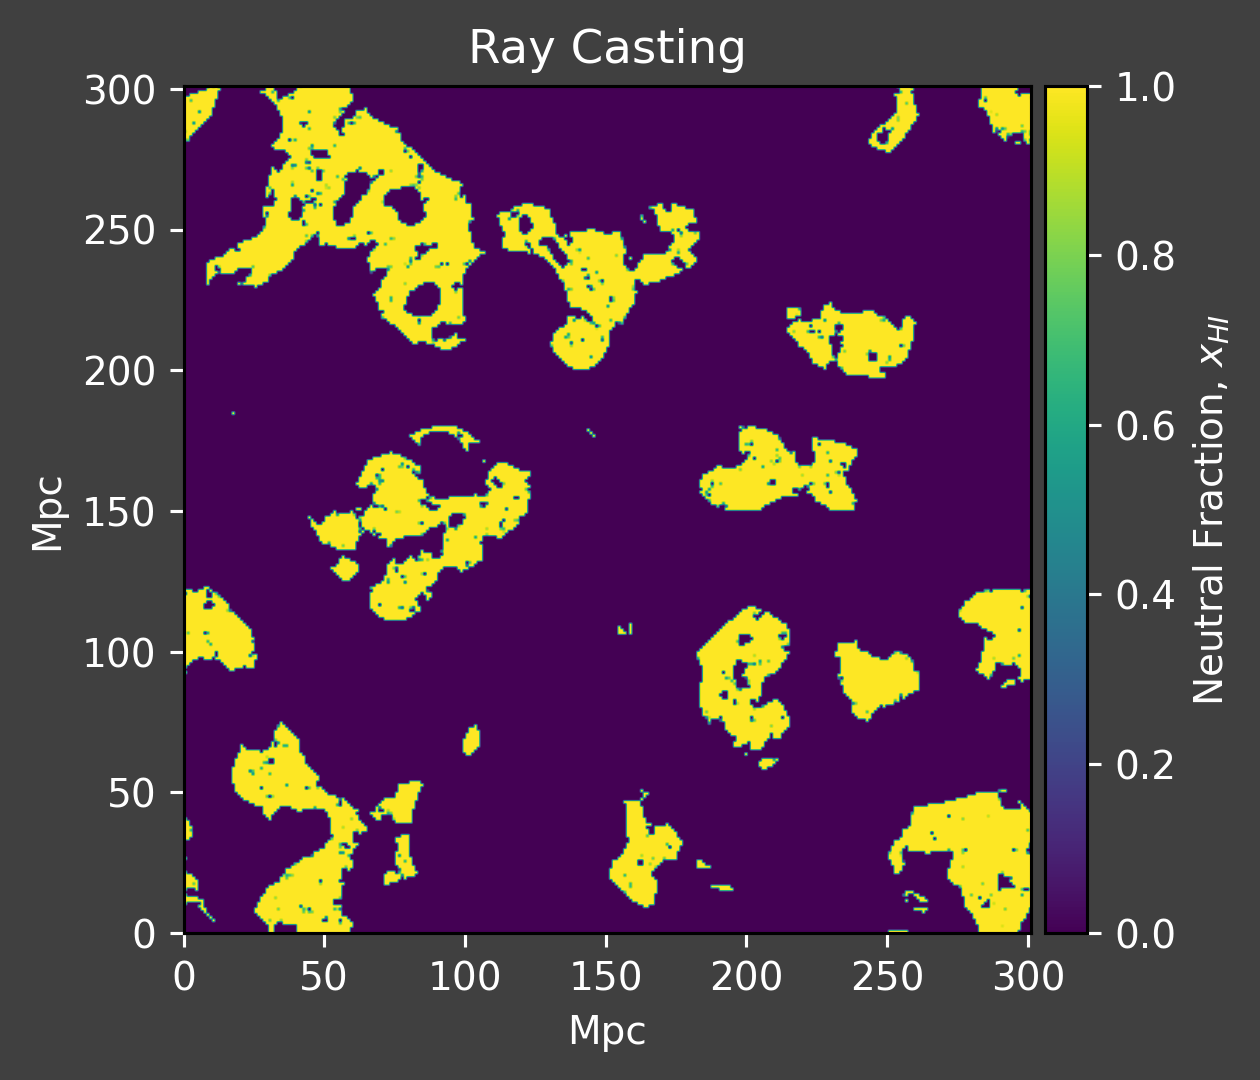

In [64]:
ray_casting_fig(0)

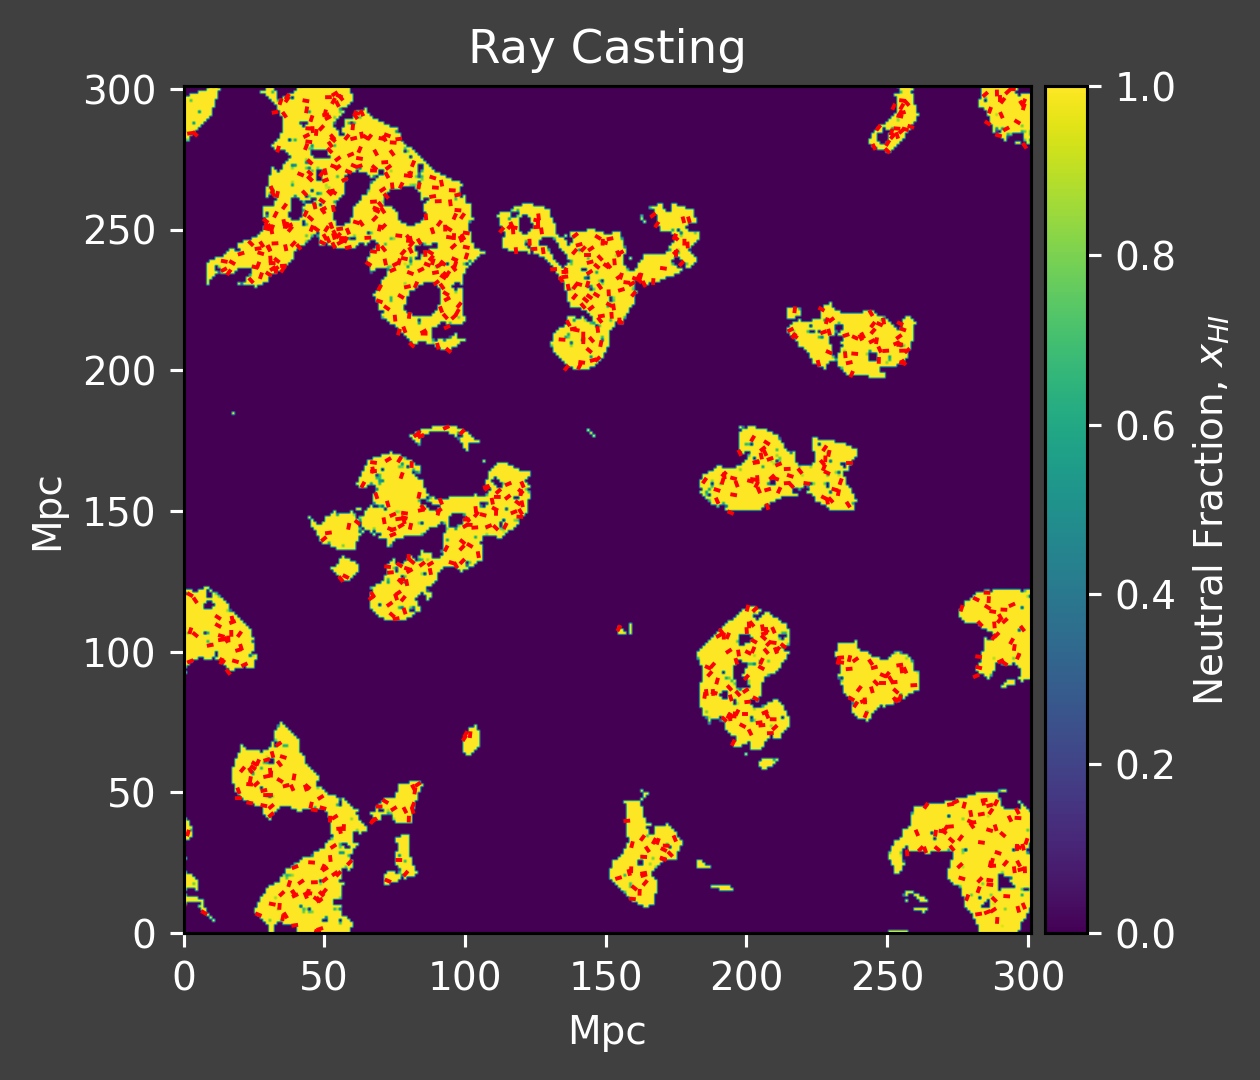

In [65]:
ray_casting_fig(1)

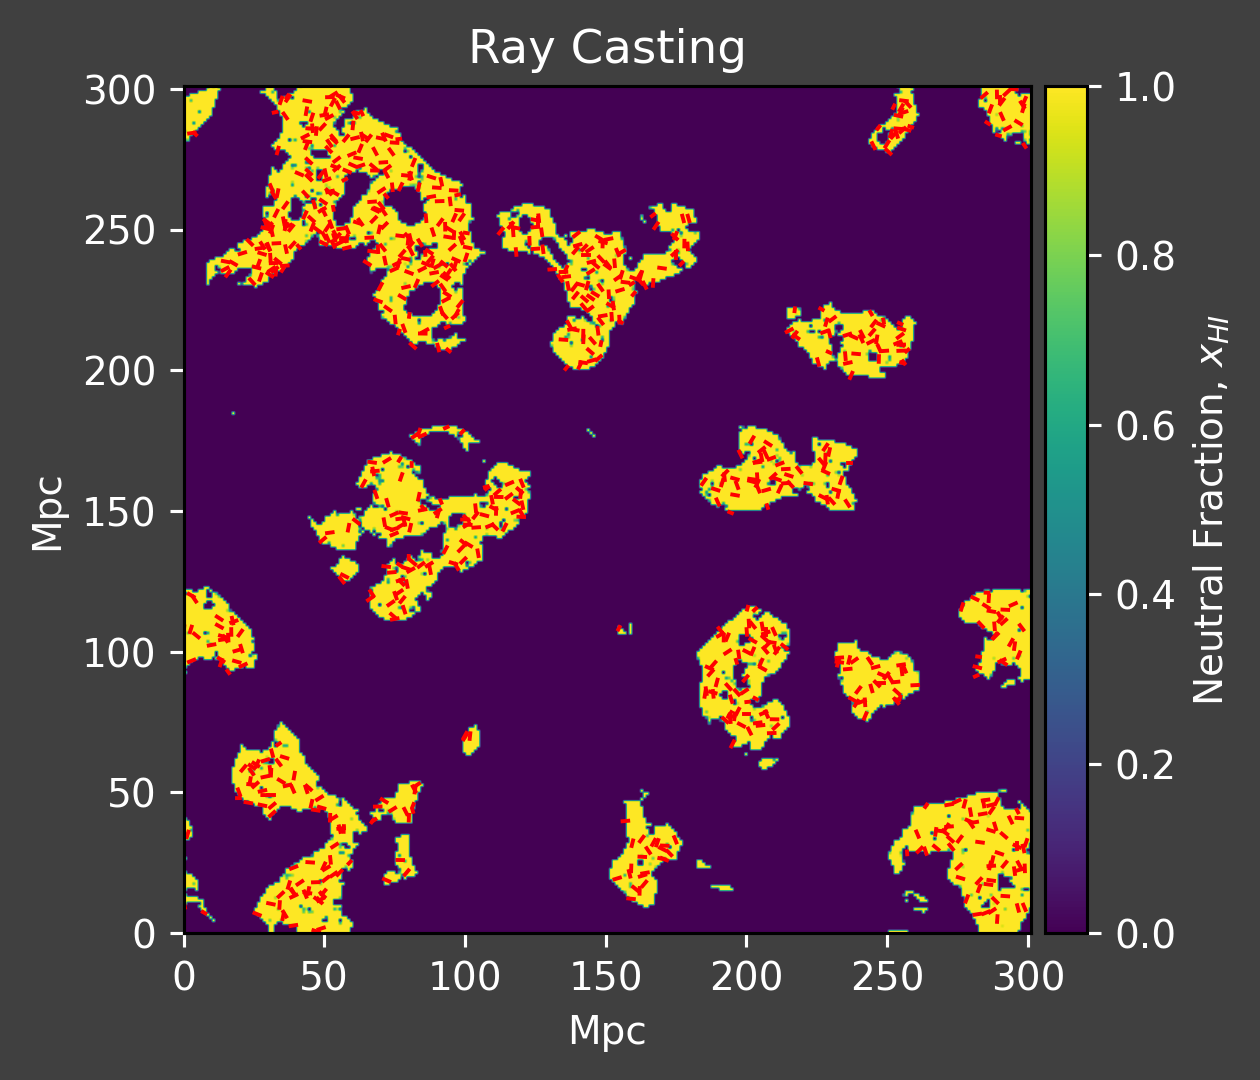

In [66]:
ray_casting_fig(2)

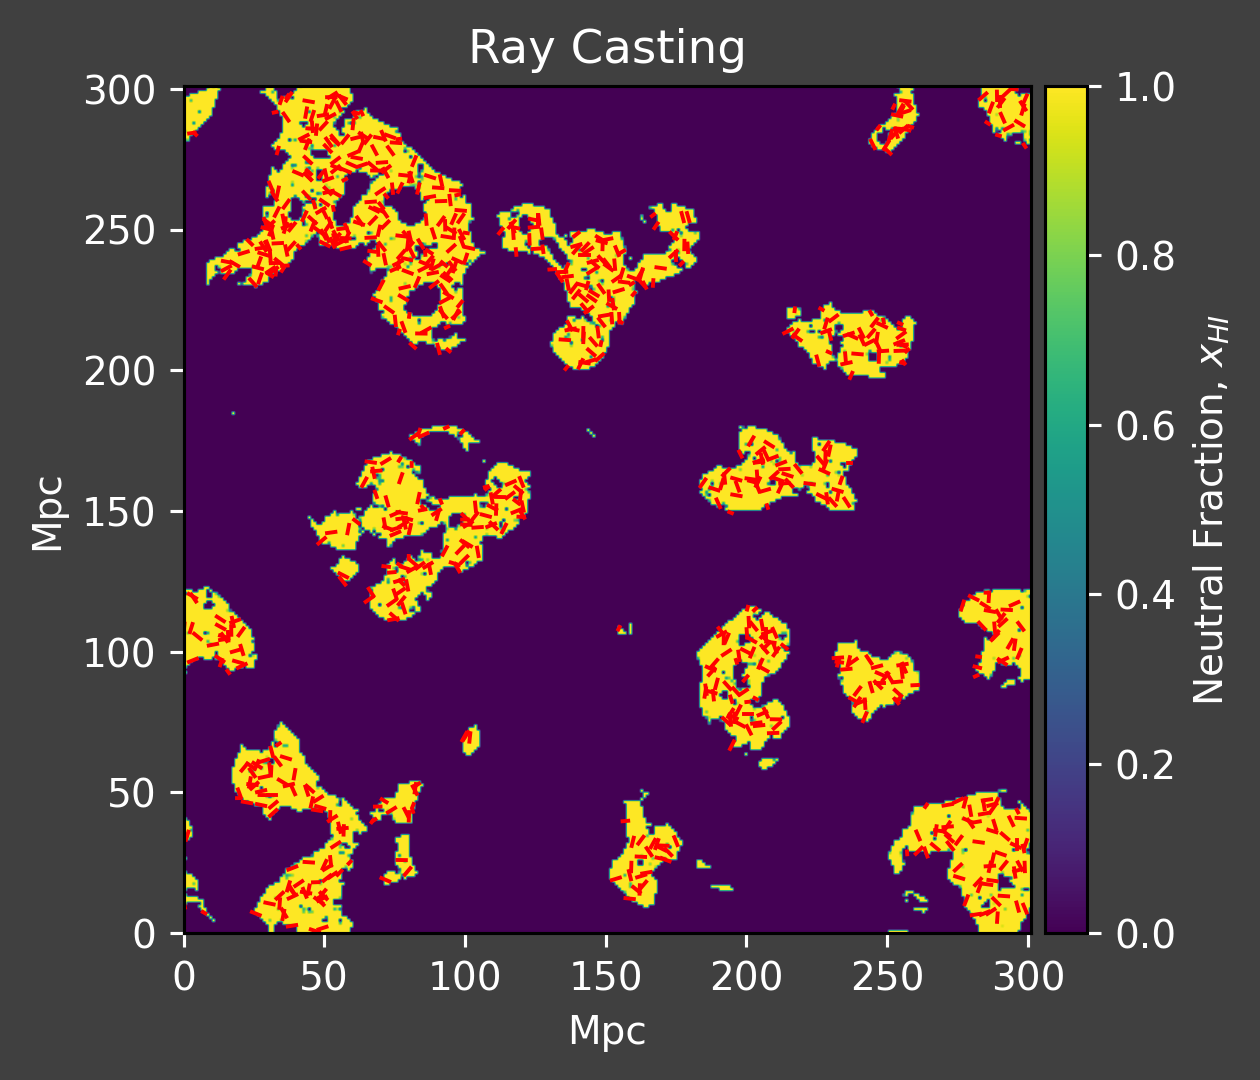

In [67]:
ray_casting_fig(3)

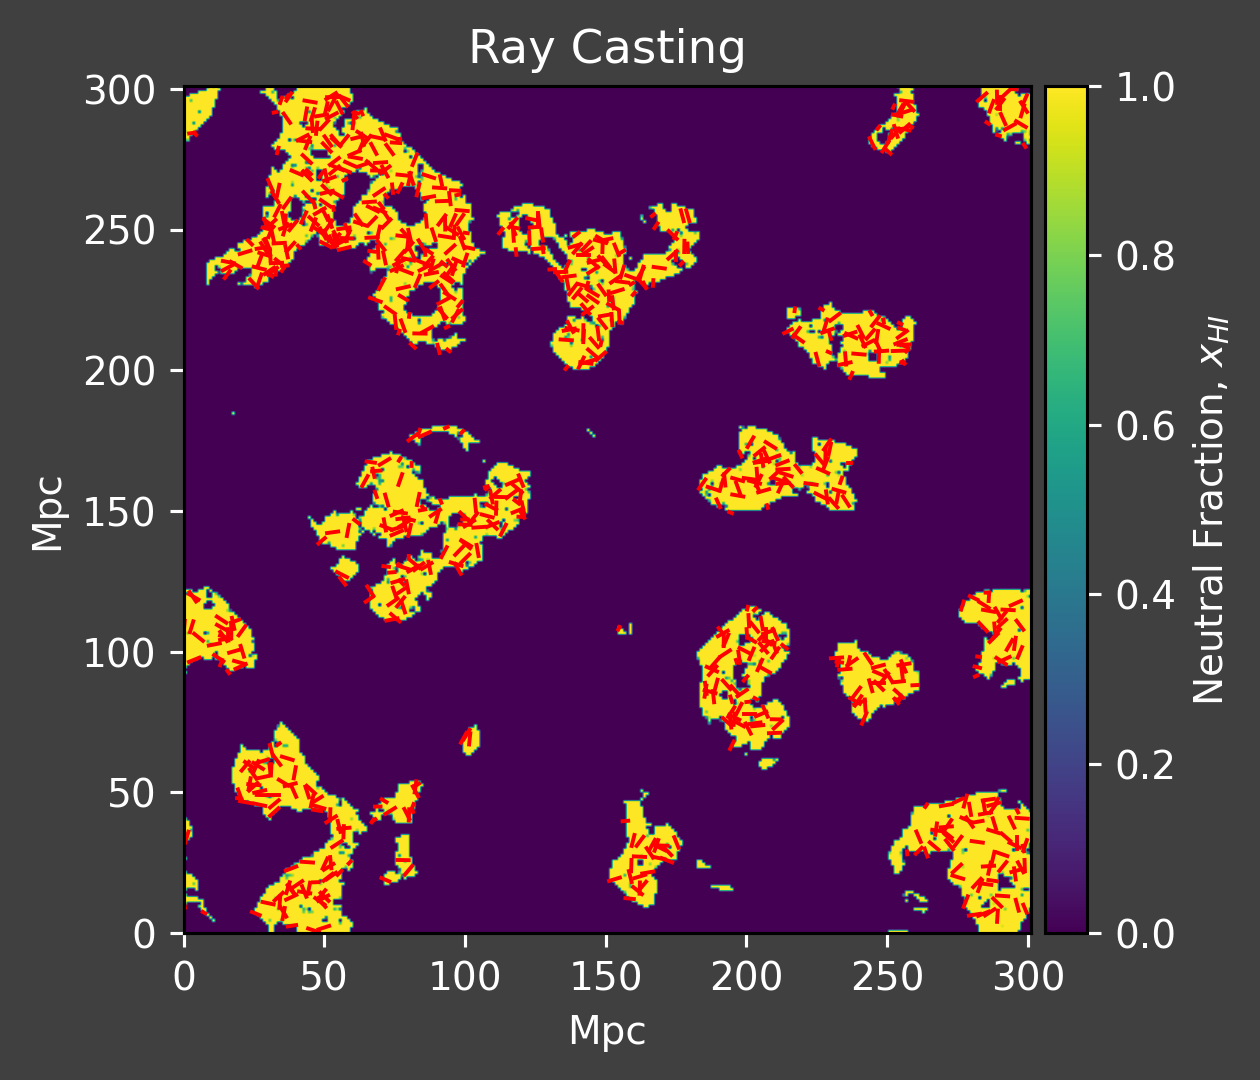

In [68]:
ray_casting_fig(4)

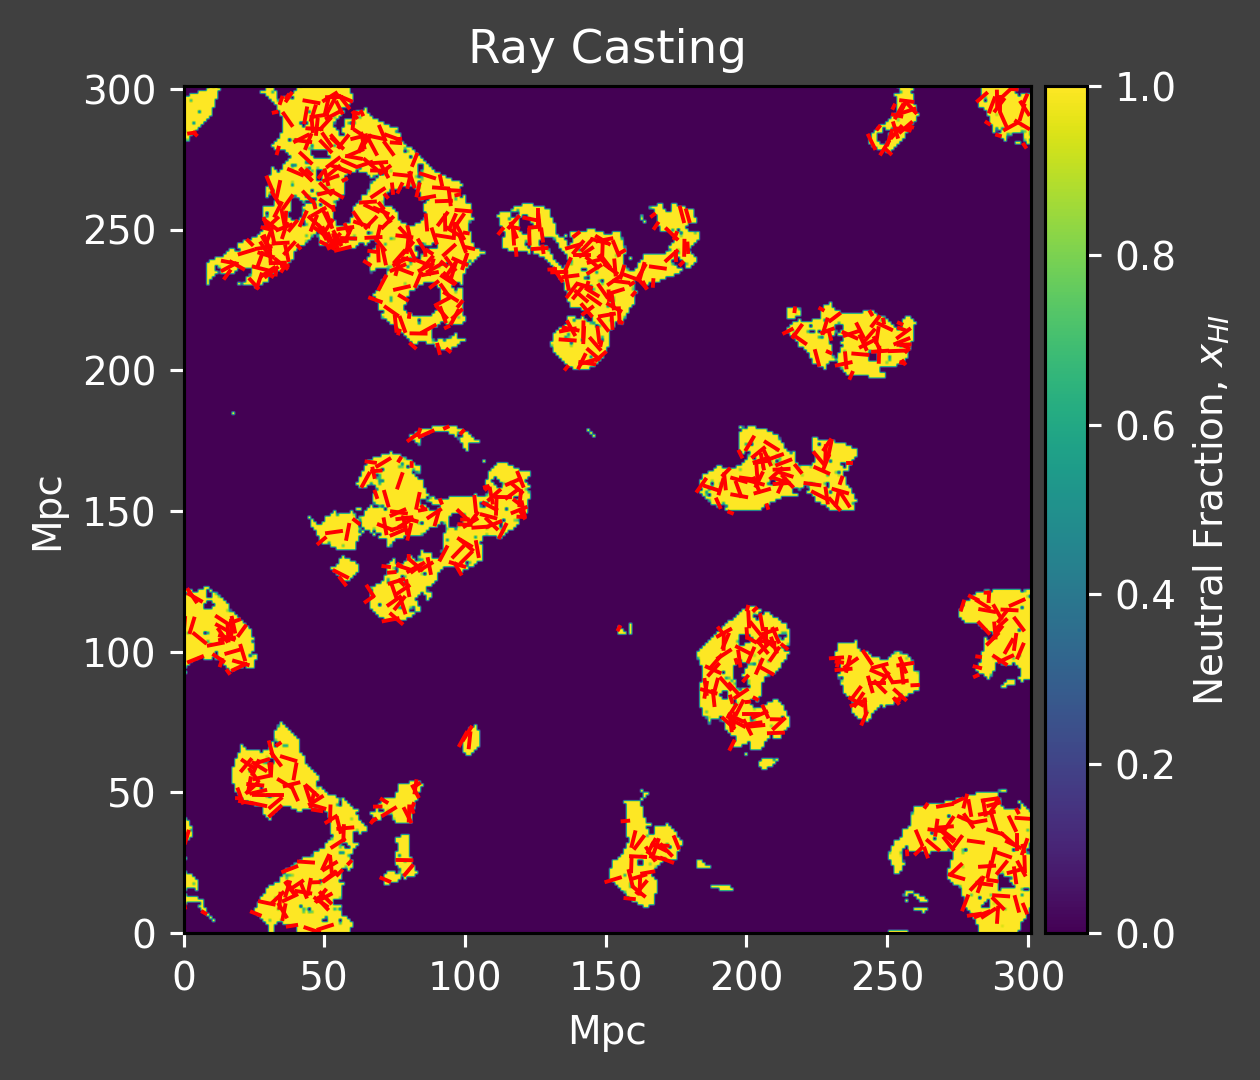

In [69]:
ray_casting_fig(5)

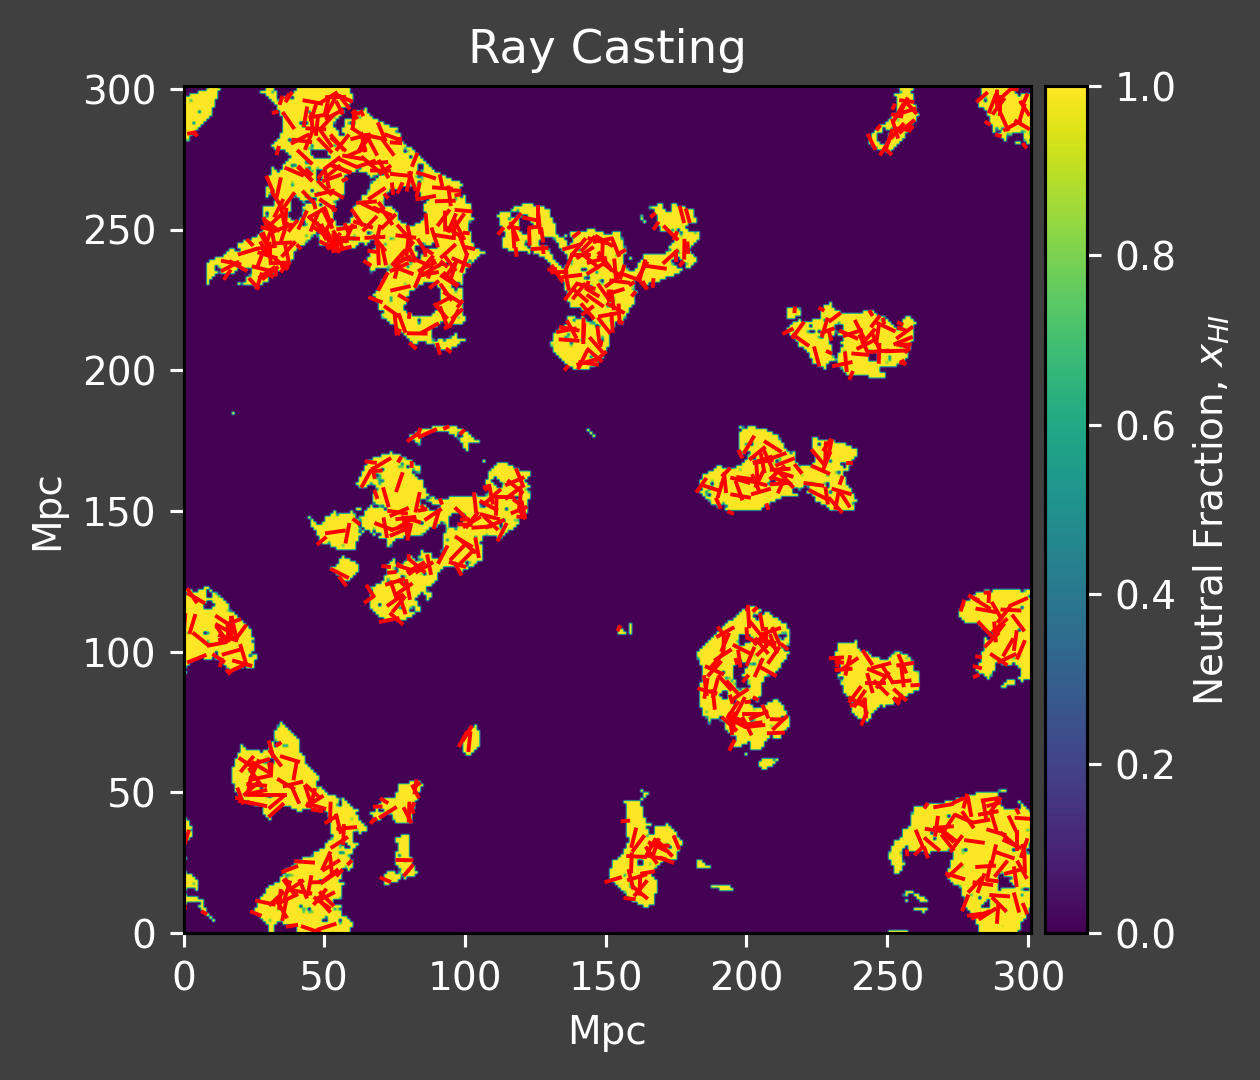

In [70]:
ray_casting_fig(6)

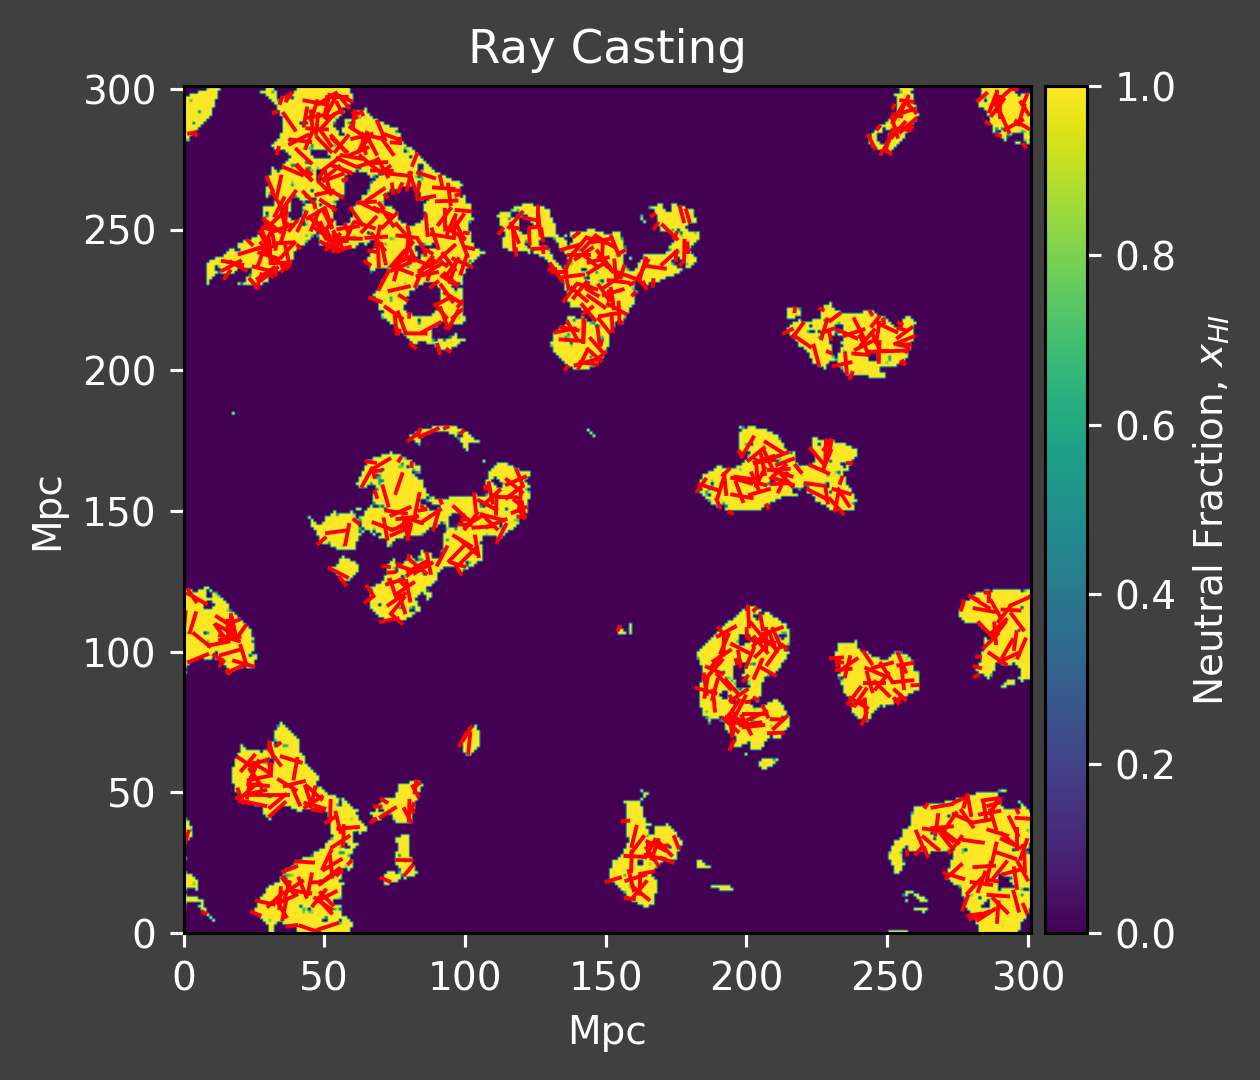

In [71]:
ray_casting_fig(7)

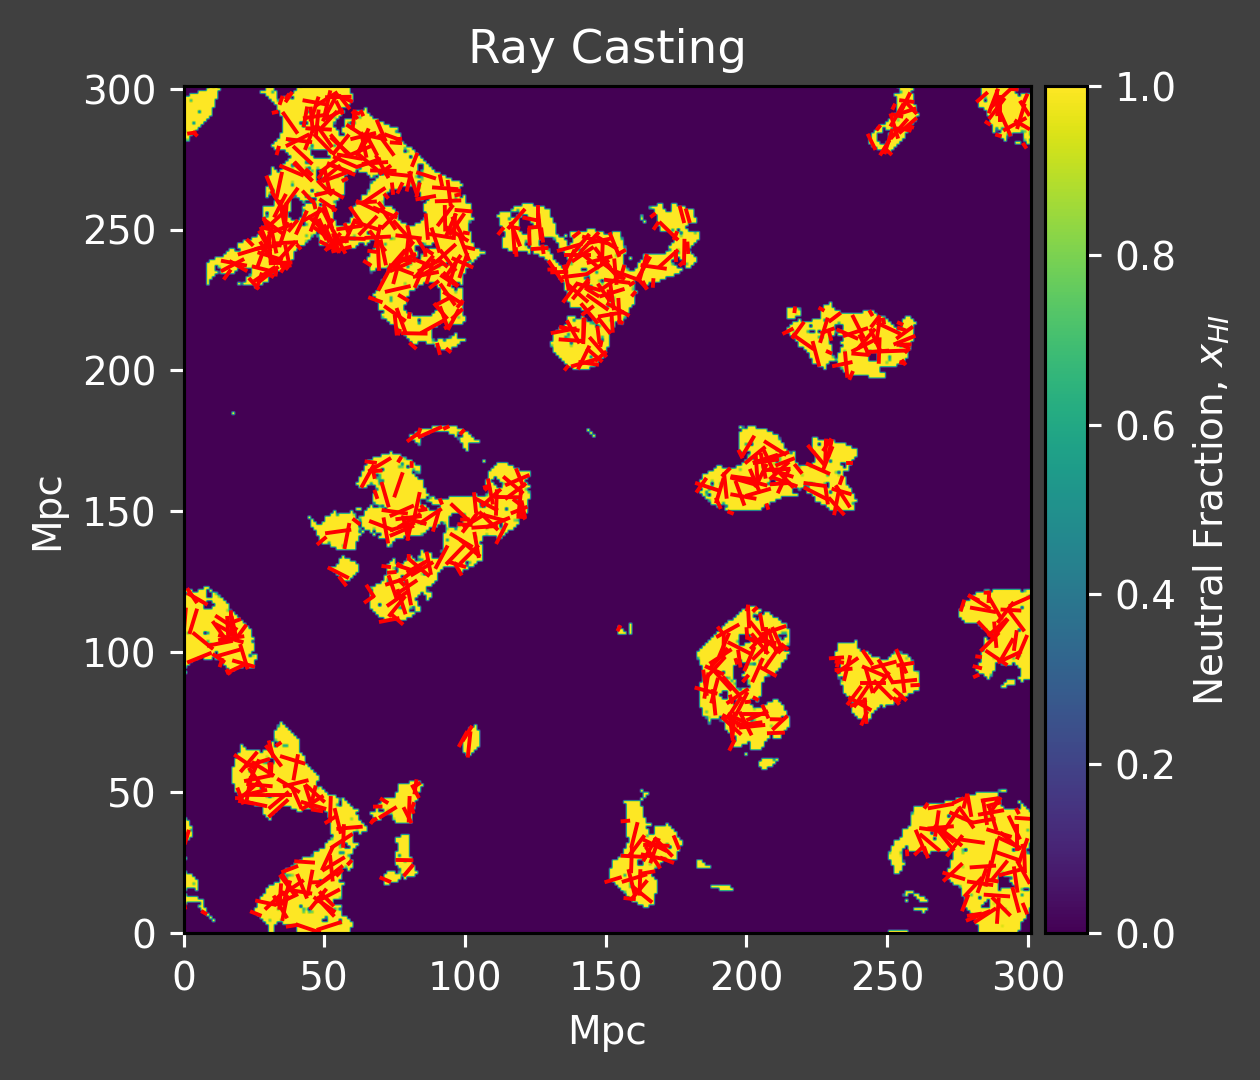

In [72]:
ray_casting_fig(8)

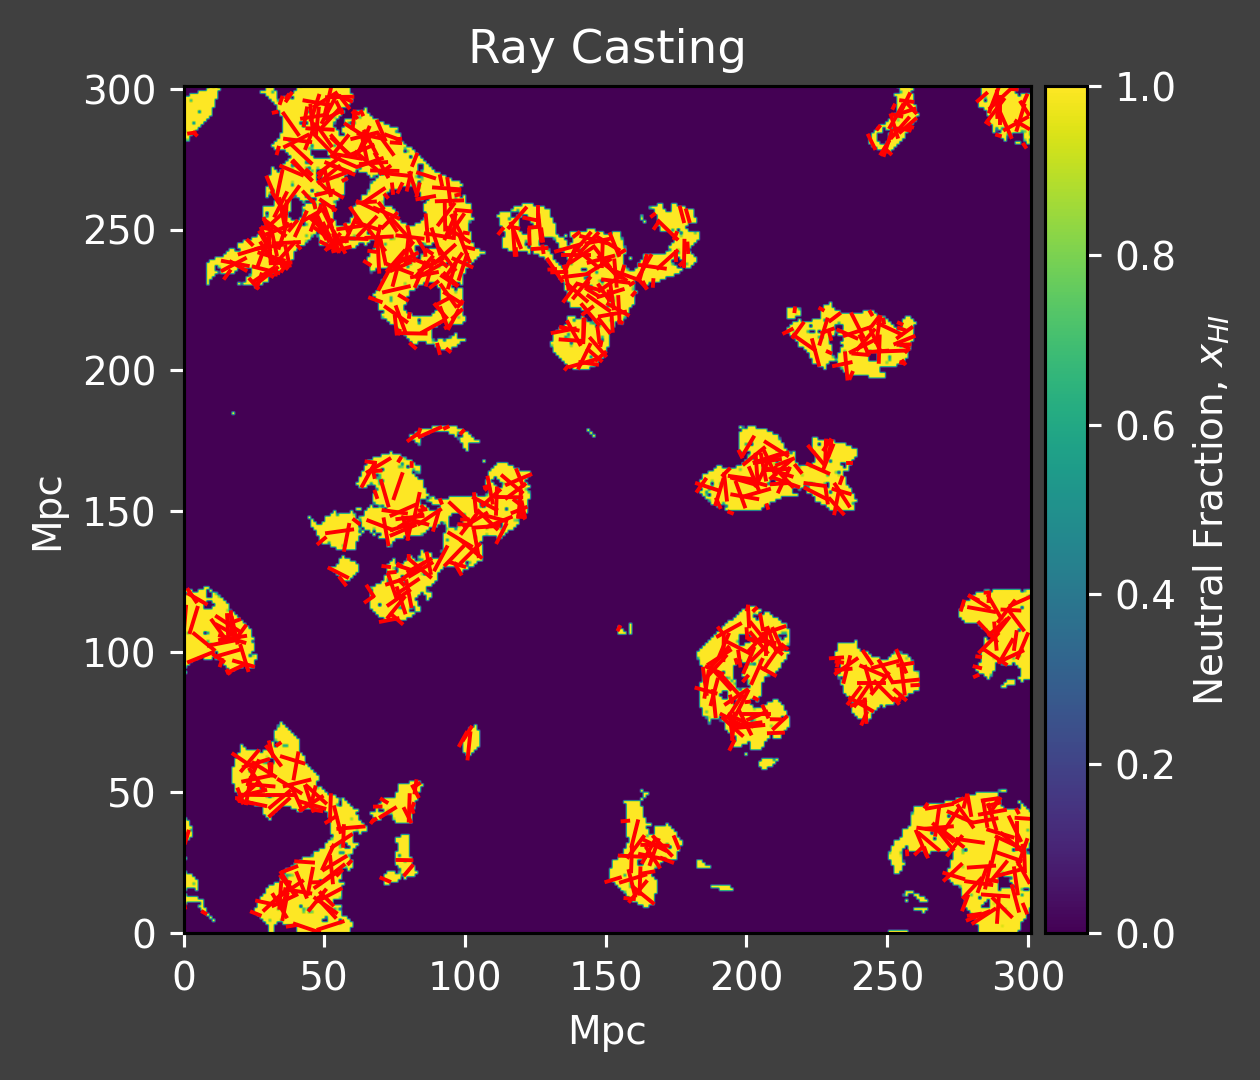

In [73]:
ray_casting_fig(9)

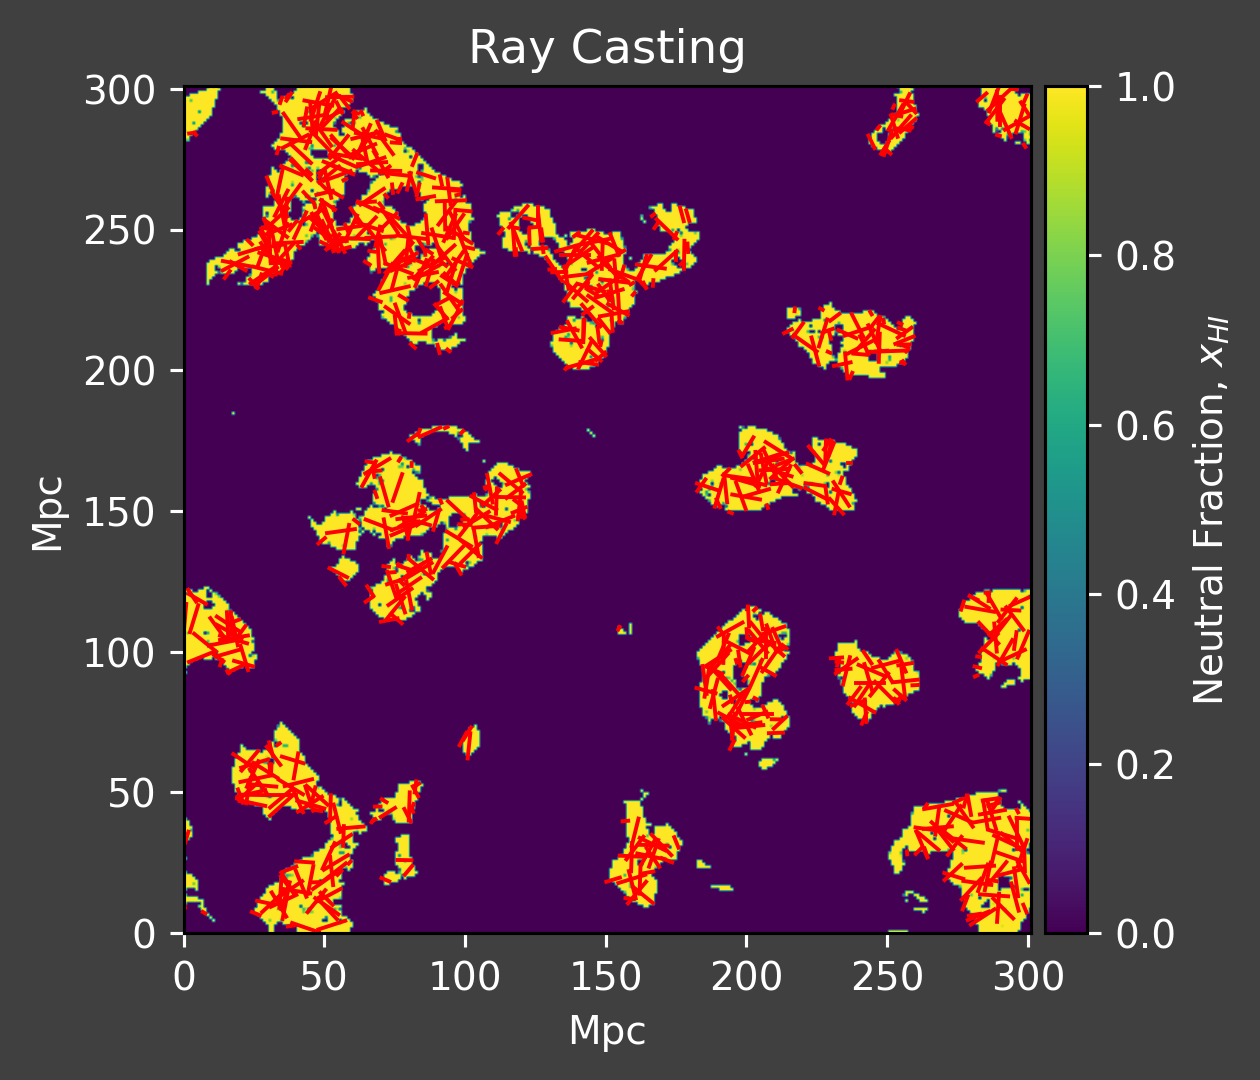

In [74]:
ray_casting_fig(10)

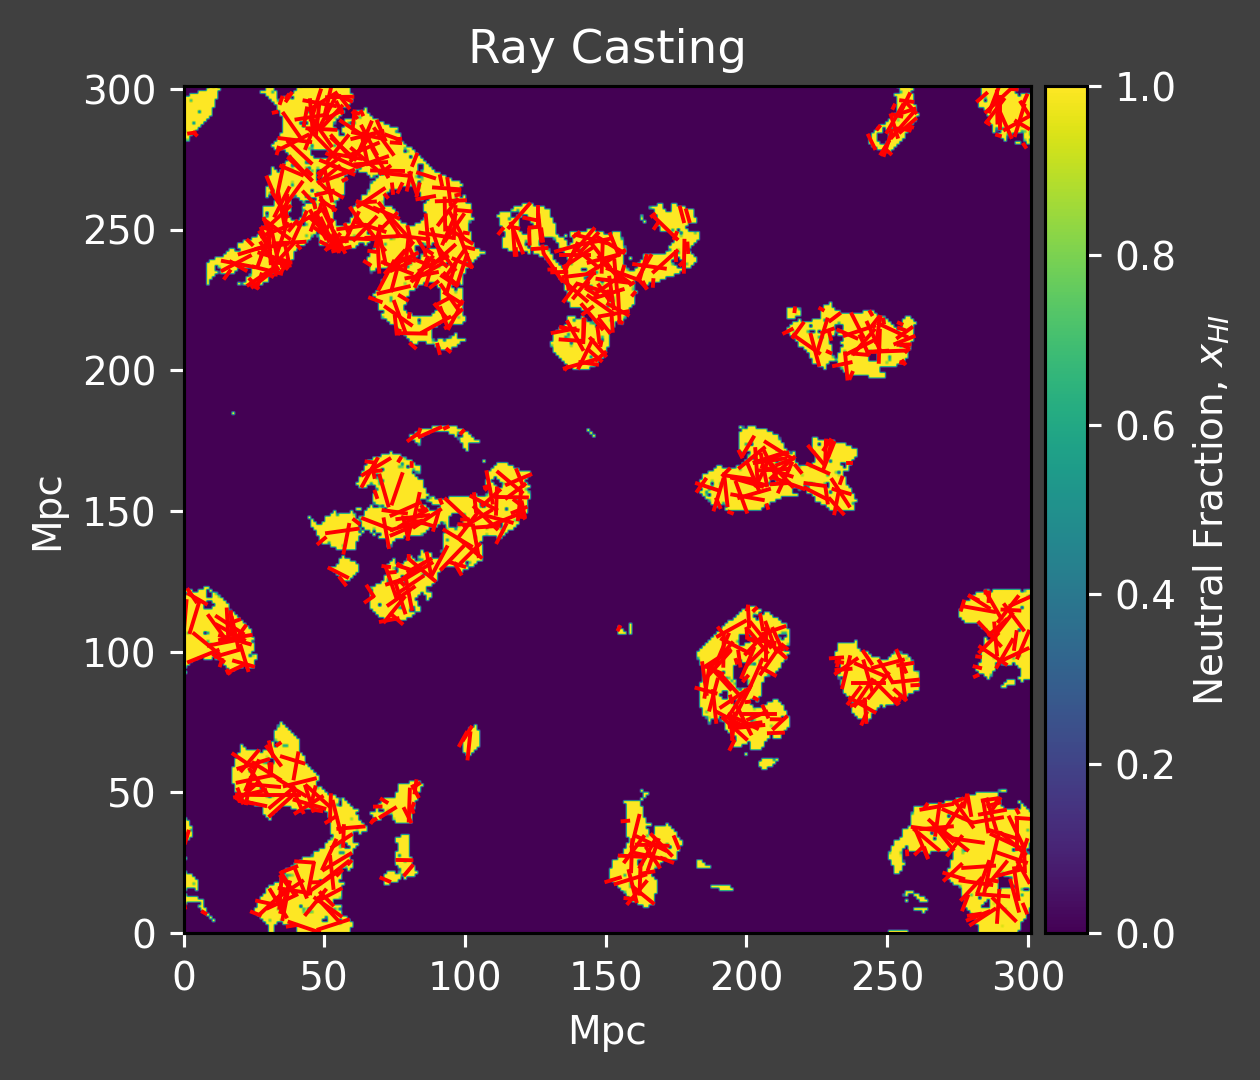

In [75]:
ray_casting_fig(11)

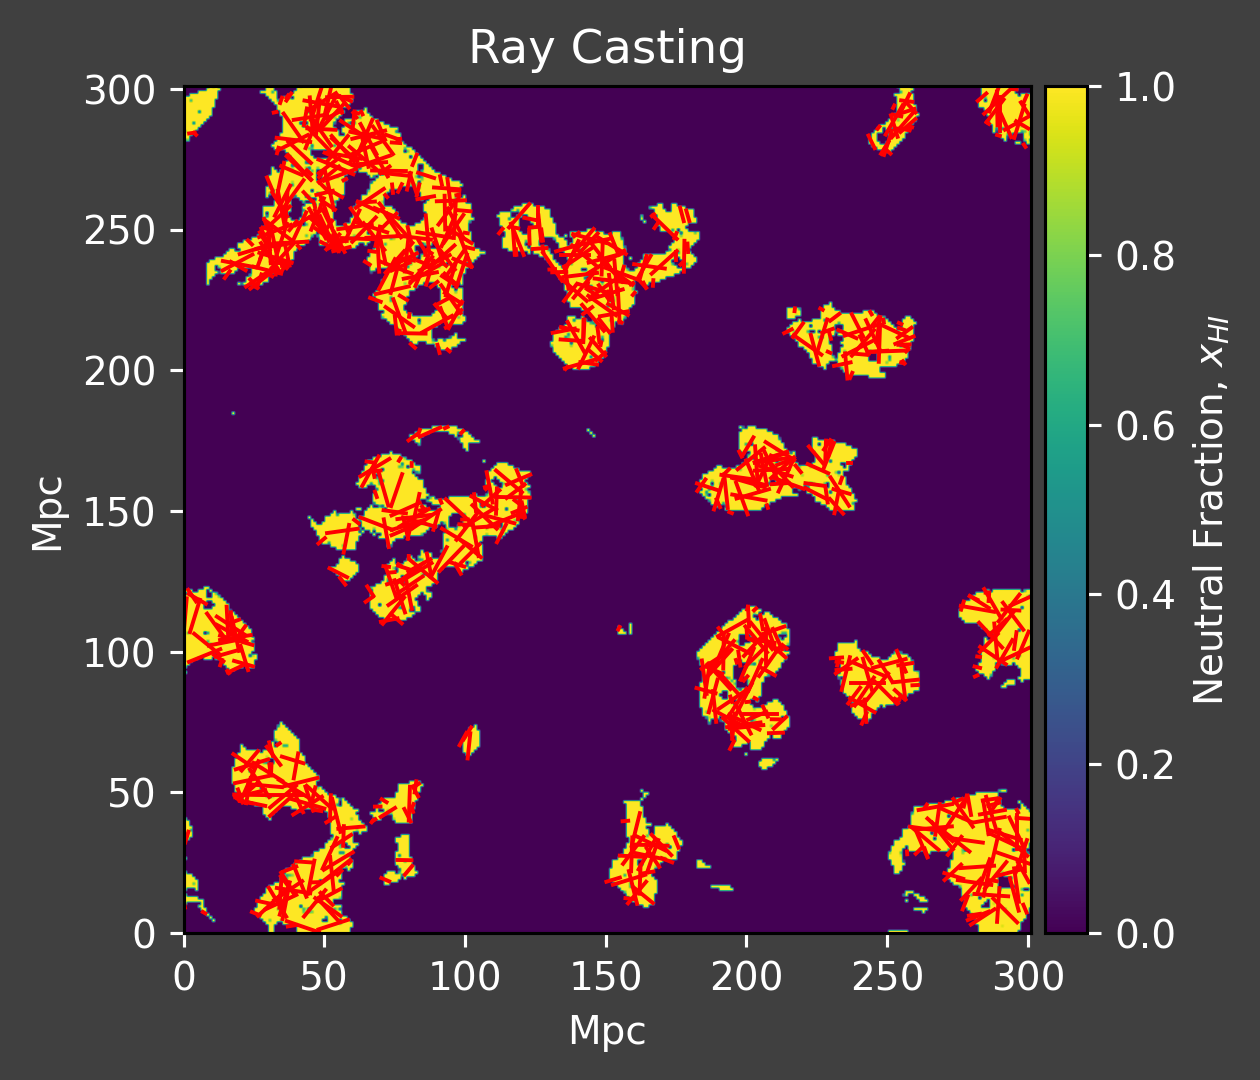

In [76]:
ray_casting_fig(12)